# Notebook to determine which .wav files should be used to train GLaDOS text-to-speech model

In [116]:
import os
from os.path import join
import glob
import subprocess
import IPython
import soundfile as sf
import numpy as np
import scipy
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
import seaborn as sns
import pandas as pd
from analysis_utils import *

np.random.seed(seed=42)

%matplotlib inline

# Load paths/prep analysis

In [2]:
# local paths,
# these will change depending on you local system
local_paths = './local_paths.tsv'
local_paths = [line.strip().split() for line in open(local_paths, 'r')]
local_paths = {i[0]:i[1] for i in local_paths}

In [3]:
# these values should be supplied by you
# DATA_PATH is where the GLaDOS .wav files are
# Wada_PATH is where WadaSNR is, see coquiTTS for more detail
# metadata_path is file name/text table generated by `download_data.py`
for i in local_paths.keys():
    print(i)

DATA_PATH
Wada_PATH
metadata_path


In [4]:
DATA_PATH = local_paths['DATA_PATH']
Wada_PATH = local_paths['Wada_PATH']
metadata_path = local_paths['metadata_path']

In [5]:
# other things to set
NUM_PROC = 1

## helpful functions for use in notebook

In [6]:
# this function if from the coquiTTS check dataset notebook
def output_snr_with_audio(idx, snr_list):
    entry = snr_list[idx]
    snr = entry[0]
    file_name = entry[-1]
    wav, sr = sf.read(file_name)
    if len(wav.shape) == 2:
        wav = wav[:, 0]
    print(f" > {file_name} - snr:{snr}")
    IPython.display.display(IPython.display.Audio(wav, rate=sr))

# Check/Compare Signal to Noise Ratio (SNR)

In [7]:
# get .wav file paths
wav_files = glob.glob(f"{local_paths['DATA_PATH']}/**/*.wav", recursive=True)

# get the SNR, file path for all the GLaDOS files
if NUM_PROC == 1:
    file_snrs = [None] * len(wav_files) 
    for idx, wav_file in tqdm(enumerate(wav_files)):
        tup = wada_snr(wav_file)
        if type(tup[0]) == np.ndarray:
            tup = (tup[0][0], tup[-1])
        file_snrs[idx] = tup
else:
    with Pool(NUM_PROC) as pool:
        file_snrs = list(tqdm(pool.imap(compute_file_snr, wav_files), total=len(wav_files)))
        
file_snrs = sorted(file_snrs)
#file_snrs[0:5]

1774it [02:35, 11.41it/s]


## GLaDOS sample low signal examples

In [8]:
# find worse SNR files
N = 10  # number of files to fetch
for i in range(N):
    output_snr_with_audio(i, file_snrs)

 > ../glados_data/GLaDOS_escape_02_spheredestroy4-01.wav - snr:3.285676460640596


 > ../glados_data/GLaDOS_escape_02_sphere_Death_Scream.wav - snr:3.92288852295132


 > ../glados_data/GLaDOS_Announcer_ding_on.wav - snr:8.400082663678193


 > ../glados_data/GLaDOS_Announcer_ding_off.wav - snr:8.40008266367821


 > ../glados_data/GLaDOS_escape_02_spheredestroy4-09.wav - snr:9.012627996508298


 > ../glados_data/GLaDOS_13_part1_endnag-7.wav - snr:10.353718717061636


 > ../glados_data/GLaDOS_post_escape_bridge_09.wav - snr:10.354253310021033


 > ../glados_data/GLaDOS_mp_hubreturn08.wav - snr:11.602986023382138


 > ../glados_data/GLaDOS_escape_02_spheredestroy1-01.wav - snr:11.93860188709386


 > ../glados_data/GLaDOS_potatos_sp_a4_finale3_tbeam09.wav - snr:13.04845662376267


## GLaDOS sample high signal examples

In [9]:
# samples with the best signal
for i in range(N):
    output_snr_with_audio(-i-1, file_snrs)

 > ../glados_data/Glados_Dota_2_gamemode_16.wav - snr:100.0


 > ../glados_data/Glados_Dota_2_gamemode_15.wav - snr:100.0


 > ../glados_data/Glados_Dota_2_gamemode_13.wav - snr:100.0


 > ../glados_data/Glados_Dota_2_gamemode_07.wav - snr:100.0


 > ../glados_data/Glados_Dota_2_gamemode_06.wav - snr:100.0


 > ../glados_data/Glados_Dota_2_gamemode_01.wav - snr:100.0


 > ../glados_data/GLaDOS_turret_intro01.wav - snr:100.0


 > ../glados_data/GLaDOS_testchambermisc35.wav - snr:100.0


 > ../glados_data/GLaDOS_testchambermisc34.wav - snr:100.0


 > ../glados_data/GLaDOS_testchambermisc23.wav - snr:100.0


## SNR distribution for GLaDOS samples

In [10]:
snrs = [i[0] for i in file_snrs]
print(f" > Average SNR of the dataset:{np.mean(snrs)}")

 > Average SNR of the dataset:52.49426209650179


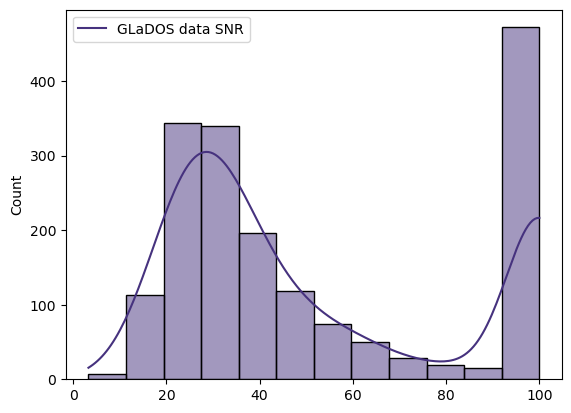

In [114]:
# Dota samples may be over represented
sns.histplot(snrs, kde=True, 
             color=sns.color_palette('viridis')[0])
plt.legend(['GLaDOS data SNR'])

In [57]:
snr_table = pd.DataFrame({'file_path':[i[-1] for i in file_snrs],
                           'SNR':[i[0] for i in file_snrs]})
snr_table['file_name'] = snr_table['file_path'].apply(lambda x: \
                                                      x.split('/')[-1] \
                                                      .replace('.wav', ''))
snr_table.head()

file_path       SNR  \
0  ../glados_data/GLaDOS_escape_02_spheredestroy4...  3.285676   
1  ../glados_data/GLaDOS_escape_02_sphere_Death_S...  3.922889   
2        ../glados_data/GLaDOS_Announcer_ding_on.wav  8.400083   
3       ../glados_data/GLaDOS_Announcer_ding_off.wav  8.400083   
4  ../glados_data/GLaDOS_escape_02_spheredestroy4...  9.012628   

                              file_name  
0    GLaDOS_escape_02_spheredestroy4-01  
1  GLaDOS_escape_02_sphere_Death_Scream  
2              GLaDOS_Announcer_ding_on  
3             GLaDOS_Announcer_ding_off  
4    GLaDOS_escape_02_spheredestroy4-09

In [58]:
metadata = pd.read_csv(metadata_path, 
                       sep='|', 
                       header=None, 
                       names=['file_name', 'text', 'also_text'])

metadata['length'] = metadata.apply(lambda x: \
                                    give_file_len(join(DATA_PATH, 
                                                       x.file_name+'.wav')), 
                                    axis=1)


# number or words
# words per second
metadata.head()

file_name                                               text  \
0  GLaDOS_00_part1_entry-1  Hello and, again, welcome to the Aperture Scie...   
1  GLaDOS_00_part1_entry-2  We hope your brief detention in the relaxation...   
2  GLaDOS_00_part1_entry-3  Your specimen has been processed and we are no...   
3  GLaDOS_00_part1_entry-4  Before we start, however, keep in mind that al...   
4  GLaDOS_00_part1_entry-5  For your own safety and the safety of others, ...   

                                           also_text     length  
0  Hello and, again, welcome to the Aperture Scie...   5.905034  
1  We hope your brief detention in the relaxation...   4.259048  
2  Your specimen has been processed and we are no...   4.888254  
3  Before we start, however, keep in mind that al...  10.194104  
4  For your own safety and the safety of others, ...   5.274966

In [59]:
metadata = metadata.merge(snr_table[['file_name', 'SNR']], 
                          on='file_name', how='left')
metadata = metadata[['file_name', 'text', 'length', 'SNR']].copy()

metadata['num_words'] = metadata['text'].apply(lambda x: len(x.split(' ')))
metadata['words_per_sec'] = metadata.num_words / metadata.length

metadata.head()

file_name                                               text  \
0  GLaDOS_00_part1_entry-1  Hello and, again, welcome to the Aperture Scie...   
1  GLaDOS_00_part1_entry-2  We hope your brief detention in the relaxation...   
2  GLaDOS_00_part1_entry-3  Your specimen has been processed and we are no...   
3  GLaDOS_00_part1_entry-4  Before we start, however, keep in mind that al...   
4  GLaDOS_00_part1_entry-5  For your own safety and the safety of others, ...   

      length        SNR  num_words  words_per_sec  
0   5.905034  27.988696         11       1.862817  
1   4.259048  20.221452         14       3.287120  
2   4.888254  30.266347         15       3.068580  
3  10.194104  33.141837         25       2.452398  
4   5.274966  27.582552         14       2.654046

In [66]:
metadata[metadata.text.str.contains('Remember when')]

file_name  \
129                   GLaDOS_escape_nags_08   
519     GLaDOS_potatos_a4_misc_resistance02   
714   GLaDOS_mp_coop_infinifling_trainend01   
1293    GLaDOS_sp_bridge_intro_completion02   

                                                   text     length  \
129   Remember when the platform was sliding into th...  11.723832   
519   Remember when I told you that he was specifica...  10.266122   
714   Remember when I told you that you were the onl...   4.597551   
1293  Say. Remember when we cleared the air back the...   9.168980   

             SNR  num_words  words_per_sec  
129    53.307812         35       2.985372  
519    19.856365         34       3.311864  
714    18.408001         16       3.480114  
1293  100.000000         19       2.072204

In [63]:
metadata.query("length > 27")

file_name  \
1235  GLaDOS_sp_sphere_2nd_encounter_entry01   

                                                   text     length        SNR  \
1235  I shouldn't spoil this, but... remember how I'...  27.297959  31.530965   

      num_words  words_per_sec  
1235         82       3.003888

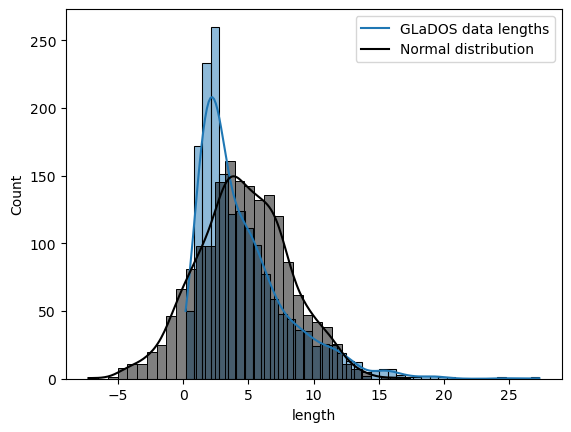

In [107]:
mu, sigma = metadata.length.mean(), metadata.length.std()
norm_lengths = np.random.normal(mu, sigma, len(metadata.length))

sns.histplot(metadata.length, kde=True)
sns.histplot(norm_lengths, kde=True, color='k')
plt.legend(['GLaDOS data lengths', 'Normal distribution'])

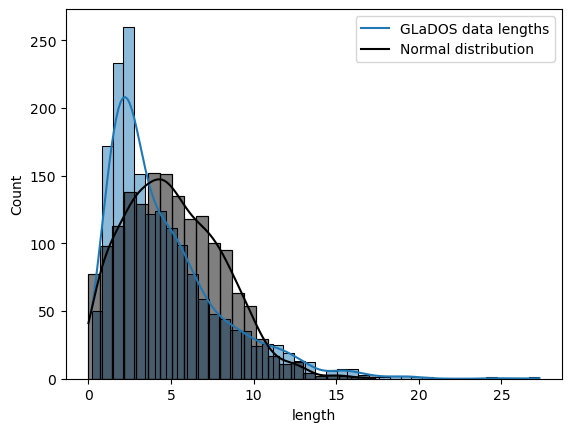

In [108]:
sns.histplot(metadata.length, kde=True)
sns.histplot(norm_lengths[norm_lengths > 0], kde=True, color='k')
plt.legend(['GLaDOS data lengths', 'Normal distribution'])

In [95]:
metadata.length.mean()

4.57233052920698

In [96]:
metadata.length.std()

3.4299941750240843

In [67]:
glados_len = metstddata.length.sum() / 60
glados_len

135.26477815570672

Let's see how the GLaDOS data we have compares to other data used to train other TTS models

In [13]:
# maybe do some character editing...
metadata[metadata.text.str.contains('\n')]

file_name  \
133            GLaDOS_escape_00_part3_nag01-1   
436     GLaDOS_potatos_remembering_caroline03   
1185  GLaDOS_dlc1_mp_coop_laser_tbeam_intro02   
1187  GLaDOS_dlc1_mp_coop_laser_tbeam_intro04   
1773                 GLaDOS_Announcer_ding_on   
1774                GLaDOS_Announcer_ding_off   

                                                   text  \
133    "Okay. I am going to kill you now." (the soun...   
436    "Yes, sir, Mister Johnson..." |  Download  | ...   
1185    "How tall are you, test subject? Four-nine? ...   
1187    "Test subject, I've been told that your moth...   
1773                                      Start chime\n   
1774                                        End chime\n   

                                              also_text  
133    "Okay. I am going to kill you now." (the soun...  
436    "Yes, sir, Mister Johnson..." |  Download  | ...  
1185    "How tall are you, test subject? Four-nine? ...  
1187    "Test subject, I've been told that your moth...  
1773                                      Start chime\n  
1774                                        End chime\n

In [24]:
pdf = merge_df.query("(length <= 3 & SNR >= 50) | length > 3 & SNR >= 9 & words_per_sec < 5 & length < 15")

file  \
0              GLaDOS_sp_laser_over_goo_entry01.txt   
1        GLaDOS_dlc1_mp_coop_tripleaxis_intro01.txt   
2               GLaDOS_taunt_robot_arm_ripple06.txt   
3    GLaDOS_sp_paint_jump_redirect_bomb_entry01.txt   
4       GLaDOS_dlc1_mp_coop_threat_death_acid01.txt   
..                                              ...   
956                     GLaDOS_mp_coop_wall_504.txt   
957       GLaDOS_mp_coop_paint_longjump_intro54.txt   
958             GLaDOS_mp_coop_paint_redirect04.txt   
959               GLaDOS_15_part1_Partyspeech-1.txt   
960         GLaDOS_mp_coop_laser_crushercrush04.txt   

                                                  text  
0                                          One moment.  
1    I call this one 'Smash'. It's an early work of...  
2                             Oh great, dancing again.  
3    You can't keep going like this forever, you kn...  
4    Focus. We  are here to defeat the enemy! We ar...  
..                                                 ...  
956                                        For safety.  
957            Is that camera is hooked into the lock?  
958  I think they wanted to punish them by not allo...  
959  What are you doing? Stop it! I... I... We are ...  
960  Blue, orange isn't a human.  The lesson on tru...  

[961 rows x 2 columns]

Empty DataFrame
Columns: [file, text]
Index: []

In [ ]:
#test_path = '/home/jovyan/wisdom/projects/text_to_speech/training_data/VCTK/txt/glados'
#test = pd.DataFrame({'file':list(os.listdir(test_path))})
#test['text'] = test['file'].apply(lambda x: open(os.path.join(test_path,x), 'r').read())
#test
#test[test.text.str.contains('\n')]